# Mohammad Sina Parvizi Motlagh - 810101394
Artificial Intelligence - CA5: **`Convolutional Neural Networks (CNNs)`** - Spring 1403 \
`Goal`: The primary goal of this project is to build a robust convolutional neural network (CNN) model that can accurately classify tweets based on their intention. The project aims to explore the effects of various parameters, such as text window size and regularization techniques, on the model's performance. By investigating these factors, the project seeks to optimize the model for better generalization and accuracy in predicting the intention behind tweets.


## Project Review
The project aimed to develop a robust convolutional neural network (CNN) for classifying tweets based on their intention. Through various stages, including data preparation, model design, training, hyperparameter tuning, and analysis, significant insights and optimizations were achieved.

Data Preparation: \
The dataset of tweets was meticulously preprocessed by converting text to lowercase, tokenizing, and removing stop words. The tokens were then mapped to word vectors using a pre-trained word2vec model. The dataset was split into training and validation sets to facilitate model evaluation.

Model Design and Training: \
A CNN architecture was designed with layers tailored for text classification. The model included multiple convolutional layers with varying kernel sizes, followed by pooling and fully connected layers. The training process utilized the Adam optimizer and the cross-entropy loss function, chosen for its suitability for classification tasks.

Hyperparameter Tuning: \
Experiments with different text window sizes revealed the impact on the model's performance. Regularization techniques, such as dropout and batch normalization, were incorporated and fine-tuned to prevent overfitting and improve generalization.

Analysis and Visualization: \
The distribution of token counts per sample was analyzed and visualized using box plots, providing insights into the data's characteristics. Performance comparisons of models with different window sizes and regularization methods highlighted the influence of these parameters on classification accuracy.

Results and Observations: \
The final model demonstrated improved performance with optimized window size and regularization settings. The analysis showed that appropriate kernel sizes in convolution layers are crucial for effective feature extraction, while dropout and batch normalization significantly enhanced the model's generalization ability.

Conclusion: \
The project successfully developed an effective CNN model for tweet classification. The experiments underscored the importance of hyperparameter tuning and regularization in achieving optimal performance. Future work could explore additional text preprocessing techniques and more advanced neural network architectures to further enhance the model's capabilities.

# Setup environment

In [1]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

In [2]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch.optim import SGD, Adam

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Model training config

In [3]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 100
NUM_CLASSES = 2
SEQUENCE_LEN = [64, 128]
CNN_FILTERS = 64

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

# Data Preparation

## Load Data

In [5]:
data = pd.read_csv('twitter-suicidal-data.csv')
data

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1
...,...,...
9114,have you ever laid on your bed at night and cr...,1
9115,the fault the blame the pain s still there i m...,1
9116,stop asking me to trust you when i m still cou...,1
9117,i never know how to handle sadness crying make...,1


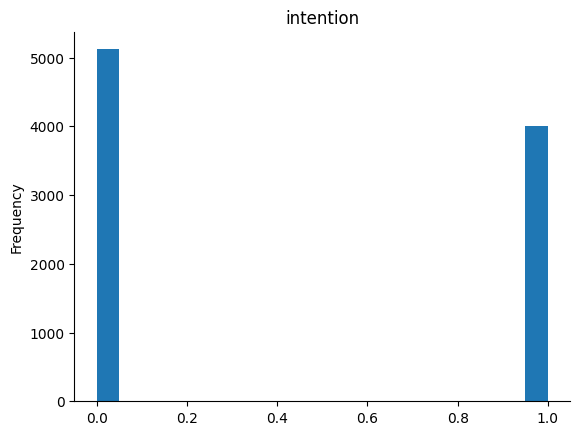

In [6]:
data['intention'].plot(kind='hist', bins=20, title='intention')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Data Preprocessing

In [7]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to C:\Users\CD
[nltk_data]     CITY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\CD
[nltk_data]     CITY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\CD
[nltk_data]     CITY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\CD CITY\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
def convert_emoji_to_text(text):
    """This function would replace emojies with a space"""
    return emoji.replace_emoji(text, replace=' ')

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """

    # TODO: lowercase the text
    text = text.lower()

    # TODO: remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # TODO: remove numbers
    text = re.sub(r'\d+', ' ', text)

    # TODO: remove urls,
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # TODO: remove usernames
    text = re.sub(r'@\w+', '', text)

    # TODO: remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # TODO: convert emojis to text
    text = convert_emoji_to_text(text)

    # TODO: remove non-word characters
    text = re.sub(r'\W', ' ', text)

    # TODO: lemmatization and tokenization of the text
    tokens = nltk.word_tokenize(text)
    nltk_tagged = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, nltk_pos_tagger(tag)) for token, tag in nltk_tagged]

    # TODO: remove stopwords
    tokens = [token for token in lemmatized_tokens if token not in stopwords]

    return tokens


In [9]:
example_text = "This is a sample tweet! Visit http://example.com 😊 #example @user"
preprocessed_tokens = preprocess_data(example_text)
print("Original text:", example_text)
print("Preprocessed tokens:", preprocessed_tokens)
print(300*'-')

sample_texts = data['tweet'].head(5)
for text in sample_texts:
    print("Original text:", text)
    print("Preprocessed tokens:", preprocess_data(text))
    print()

Original text: This is a sample tweet! Visit http://example.com 😊 #example @user
Preprocessed tokens: ['sample', 'tweet', 'visit', 'example', 'user']
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original text: my life is meaningless i just want to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives
Preprocessed tokens: ['life', 'meaningless', 'want', 'end', 'life', 'badly', 'life', 'completely', 'empty', 'dont', 'want', 'create', 'meaning

# Word2Vec - Word Embedding

In [10]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [12]:
W2V_PATH = './model/word2vec.model' # Path to W2V if downloaded
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

Loading Word2Vec model...
Word2Vec model is loaded.


In [13]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size
EMBEDDING_VECTOR_DIM

300

# Dataset

In [61]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"

        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

        # Add padding
        # self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
        # TODO: Return a 2D tensor for whole list of tokens, using vectors from w2v as explained on the description
        matrix = np.zeros((self.max_sequence_len, self.vector_size))
        for i, token in enumerate(tokens):
            if i >= self.max_sequence_len:
                break
            if token in self.w2v_model:
                matrix[i] = self.w2v_model[token]
            else:
                matrix[i] = [0] * 300
        return self._to_tensor(matrix)


    def _pad(self, tokens: list):
        # TODO: Add paddings (zero-vectors) into the end of sequence to reach the desired length
        if len(tokens) < self.max_sequence_len:
            tokens.extend([300*[0]] * ((self.max_sequence_len) - len(tokens)))
        else:
            tokens = tokens[:self.max_sequence_len]
        return tokens


    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

# Prepare Data

## Split Data into train-valid

In [44]:
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=42)

## Create Datasets

In [45]:
train_dataset = Twitter(
    dataframe=train_df, w2v_model=w2v_model, sequence_len=SEQUENCE_LEN[0]
)
valid_dataset = Twitter(
    dataframe=valid_df, w2v_model=w2v_model, sequence_len=SEQUENCE_LEN[0]
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

Deleted 0-Len Samples: 23


C:\Users\CD CITY\AppData\Local\Temp\ipykernel_10408\2494272.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


Deleted 0-Len Samples: 8
Train dataset length: 7272
Valid dataset length: 1816


C:\Users\CD CITY\AppData\Local\Temp\ipykernel_10408\2494272.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [32]:
print(train_dataset.seq_report())
print(valid_dataset.seq_report())

Sequence Length Report
:::::MAX  LENGTH:::[2142 ]
:::::MIN  LENGTH:::[  1  ]
:::::MEAN LENGTH:::[37.602722772277225]
Sequence Tokenization Report
:::::All Unique Tokens:::[18022 
:::::All Valid Tokens:::[11630 
:::::Valid Tokens:::[64.53%]
None
Sequence Length Report
:::::MAX  LENGTH:::[ 507 ]
:::::MIN  LENGTH:::[  1  ]
:::::MEAN LENGTH:::[36.86508810572687]
Sequence Tokenization Report
:::::All Unique Tokens:::[ 7797 
:::::All Valid Tokens:::[ 5859 
:::::Valid Tokens:::[75.14%]
None


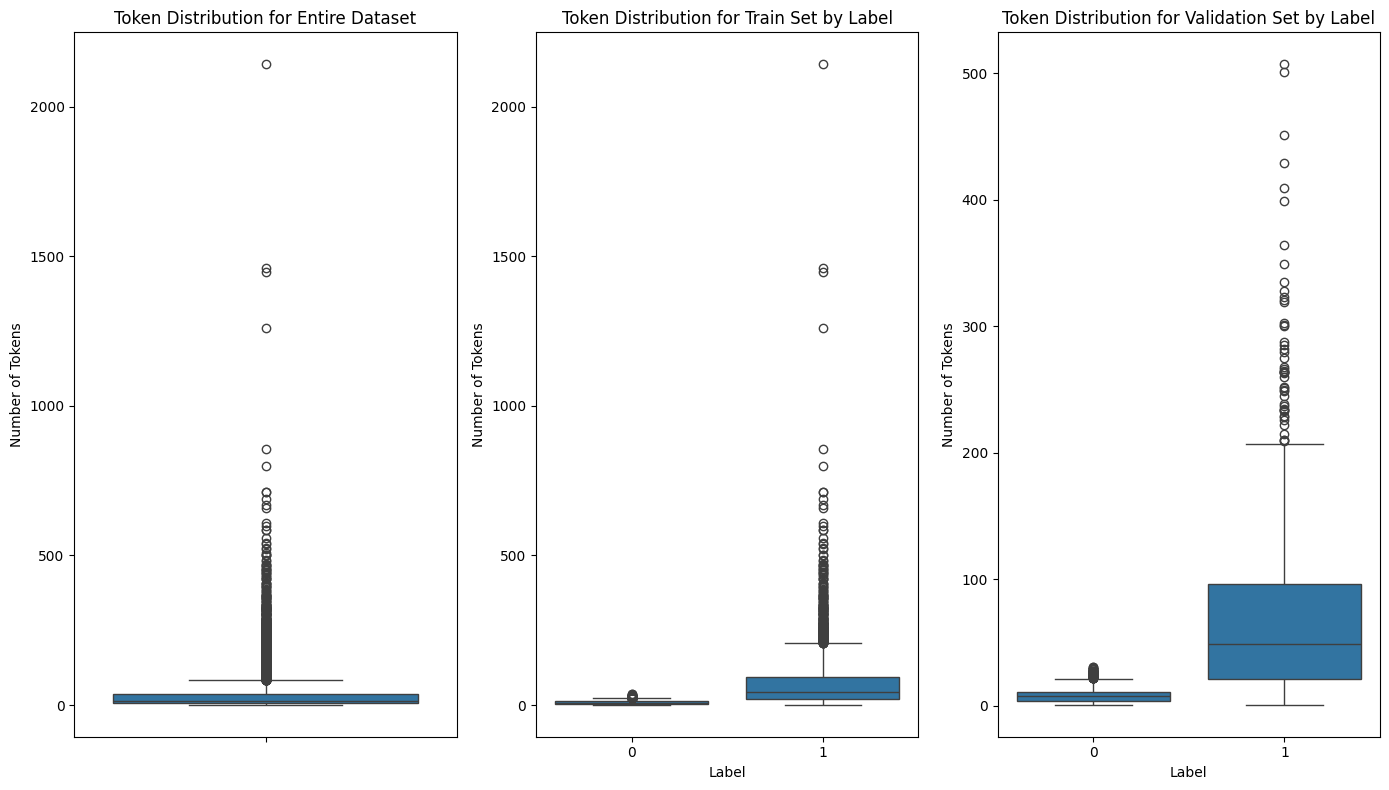

Overall token length statistics:
count    9088.000000
mean       37.455326
std        71.883728
min         1.000000
25%         6.000000
50%        12.000000
75%        37.000000
max      2142.000000
Name: length, dtype: float64

Token length statistics for train set:
count    7272.000000
mean       37.602723
std        74.838175
min         1.000000
25%         6.000000
50%        12.000000
75%        37.000000
max      2142.000000
Name: tokens, dtype: float64

Token length statistics for validation set:
count    1816.000000
mean       36.865088
std        58.592885
min         1.000000
25%         6.000000
50%        12.000000
75%        40.000000
max       507.000000
Name: tokens, dtype: float64



In [60]:
def plot_token_distribution(train_dataset, valid_dataset):
    train_lengths = train_dataset.dataframe["tokens"].map(len)
    valid_lengths = valid_dataset.dataframe["tokens"].map(len)

    lengths_df = pd.DataFrame({
        'length': pd.concat([train_lengths, valid_lengths], ignore_index=True),
        'dataset': ['train'] * len(train_lengths) + ['valid'] * len(valid_lengths),
        'label': pd.concat([train_dataset.dataframe['intention'], valid_dataset.dataframe['intention']], ignore_index=True)
    })

    plt.figure(figsize=(14, 8))

    plt.subplot(1, 3, 1)
    sns.boxplot(y='length', data=lengths_df)
    plt.title('Token Distribution for Entire Dataset')
    plt.ylabel('Number of Tokens')

    plt.subplot(1, 3, 2)
    sns.boxplot(x='label', y='length', data=lengths_df[lengths_df['dataset'] == 'train'])
    plt.title('Token Distribution for Train Set by Label')
    plt.xlabel('Label')
    plt.ylabel('Number of Tokens')

    plt.subplot(1, 3, 3)
    sns.boxplot(x='label', y='length', data=lengths_df[lengths_df['dataset'] == 'valid'])
    plt.title('Token Distribution for Validation Set by Label')
    plt.xlabel('Label')
    plt.ylabel('Number of Tokens')

    plt.tight_layout()
    plt.show()

    print("Overall token length statistics:")
    print(lengths_df['length'].describe())
    print()

    print("Token length statistics for train set:")
    print(train_lengths.describe())
    print()

    print("Token length statistics for validation set:")
    print(valid_lengths.describe())
    print()


plot_token_distribution(train_dataset, valid_dataset)

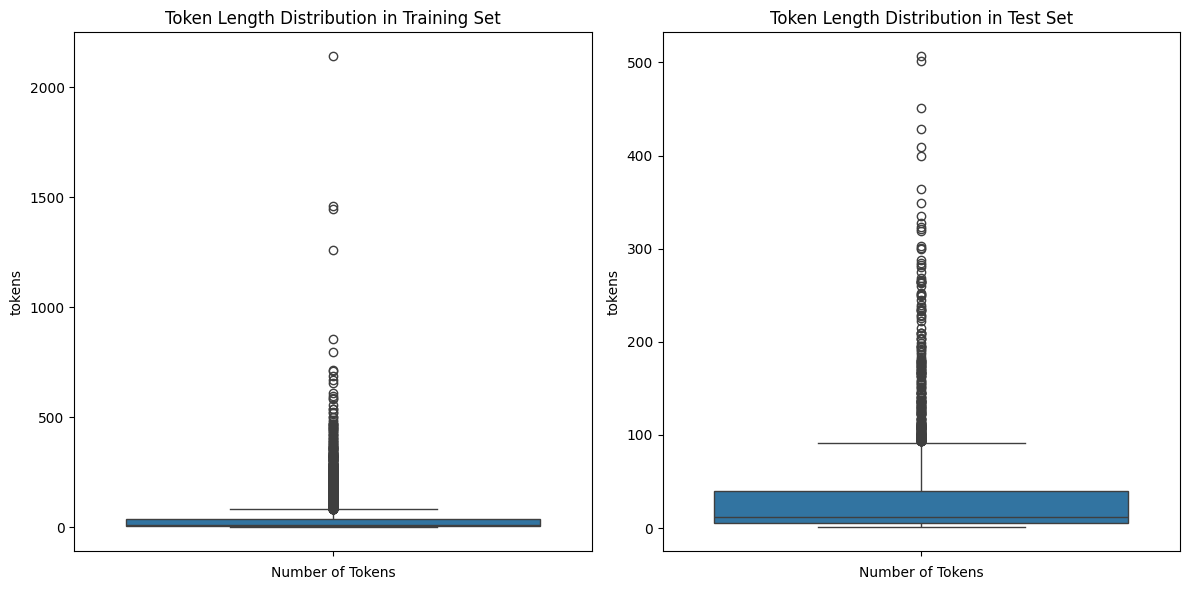

Training Set Token Lengths:
Min: 1, Max: 2142, Mean: 37.602722772277225
\Valid Set Token Lengths:
Min: 1, Max: 507, Mean: 36.86508810572687


In [62]:
train_lengths = train_dataset.dataframe["tokens"].map(len)
test_lengths = valid_dataset.dataframe["tokens"].map(len)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(train_lengths)
plt.title("Token Length Distribution in Training Set")
plt.xlabel("Number of Tokens")

plt.subplot(1, 2, 2)
sns.boxplot(test_lengths)
plt.title("Token Length Distribution in Test Set")
plt.xlabel("Number of Tokens")

plt.tight_layout()
plt.show()

print("Training Set Token Lengths:")
print(f"Min: {train_lengths.min()}, Max: {train_lengths.max()}, Mean: {train_lengths.mean()}")

print("\Valid Set Token Lengths:")
print(f"Min: {test_lengths.min()}, Max: {test_lengths.max()}, Mean: {test_lengths.mean()}")

# Model and Train

## Utils

In [20]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device: str = 'auto'):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    correct = 0
    total = 0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # Move model's inputs to `device`
        inputs, labels = inputs.to(device), labels.to(device)

        # Use model's forward pass to generate outputs
        outputs = model(inputs)

        # Calculate model's loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        # Calculate/update model's accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_acc = correct / total

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )

    test_loss /= len(loader)
    return test_loss, test_acc


In [22]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: list['cuda', 'cpu', 'auto'],
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:",device)
    model.to(device)
    print("model", model)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    model.to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        itr = tqdm(train_loader, total=len(train_loader), leave=False)

        for idx, (inputs, labels) in enumerate(itr, start=1):
            inputs, labels = inputs.to(device), labels.to(device)



            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            epoch_acc += torch.sum(preds == labels.data).item() / len(labels)

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(loss=round(loss.item(), 5),
                             accuracy=round(epoch_acc, 5))

        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(epoch_acc / len(train_loader))

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
        )

        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    history = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "valid_loss": valid_losses,
        "valid_acc": valid_accs,
    }
    return history


In [24]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [25]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    true_preds, num_preds = 0., 0.
    reality = []
    predicts = []

    model.eval()
    for tweet, labels in itr:
        tweet = tweet.to(device)
        preds = model(tweet)
        preds = preds.squeeze(dim=0)
        preds = torch.sigmoid(preds)
        pred_labels = ([torch.argmax(i) for i in preds])
        pred_labels = torch.tensor([i.item() for i in pred_labels])
        true_preds += (pred_labels == labels).sum()
        num_preds += labels.shape[0]
        for p , r in zip(pred_labels,labels):
            predicts.append(p)
            reality.append(r)

    cm = metrics.confusion_matrix(
        y_true=reality,
        y_pred=predicts,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=reality, y_pred=predicts, average='macro')
    f1 = metrics.f1_score(y_true=reality, y_pred=predicts, average='macro')
    precision = metrics.precision_score(y_true=reality, y_pred=predicts, average='macro')
    report = metrics.classification_report(y_true=reality, y_pred=predicts)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

In [71]:
class CNN(nn.Module): # the suggested network
    def __init__(self, input_dim=300, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()

        # first layer
        self.conv1_3 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3)
        self.conv1_5 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5)
        self.conv1_7 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=7)

        # second layer
        self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv2_5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5)
        self.conv2_7 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7)

        # activation function
        self.relu = nn.ReLU()

        # max poolinf layer
        self.maxpool = nn.AdaptiveMaxPool1d(output_size=1)

        # flatten layer
        self.flatten = nn.Flatten()

        # fully connected layes
        self.fc1 = nn.Linear(in_features=3 * 128, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))

        # First convolutional block
        x1 = self.relu(self.conv1_3(x))
        x2 = self.relu(self.conv1_5(x))
        x3 = self.relu(self.conv1_7(x))


        # Second convolutional block
        x1 = self.relu(self.conv2_3(x1))
        x2 = self.relu(self.conv2_5(x2))
        x3 = self.relu(self.conv2_7(x3))


        # Local maxpooling
        x1 = self.maxpool(x1)
        x2 = self.maxpool(x2)
        x3 = self.maxpool(x3)

        # Concatenate along feature dimension
        x = torch.cat((x1, x2, x3), dim=2)

        # Flatten the output
        x = self.flatten(x)

        # Apply fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training

### Here i have implemented the suggested network

In [74]:
model_1 = CNN(input_dim=EMBEDDING_VECTOR_DIM, num_classes=NUM_CLASSES)

In [75]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model_1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

cnn_model_train_history = train_model(
    model=model_1,
    batch_size=BATCH_SIZE,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=DEVICE
)

device: cuda
model CNN(
  (conv1_3): Conv1d(300, 64, kernel_size=(3,), stride=(1,))
  (conv1_5): Conv1d(300, 64, kernel_size=(5,), stride=(1,))
  (conv1_7): Conv1d(300, 64, kernel_size=(7,), stride=(1,))
  (conv2_3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (conv2_5): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (conv2_7): Conv1d(64, 128, kernel_size=(7,), stride=(1,))
  (relu): ReLU()
  (maxpool): AdaptiveMaxPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


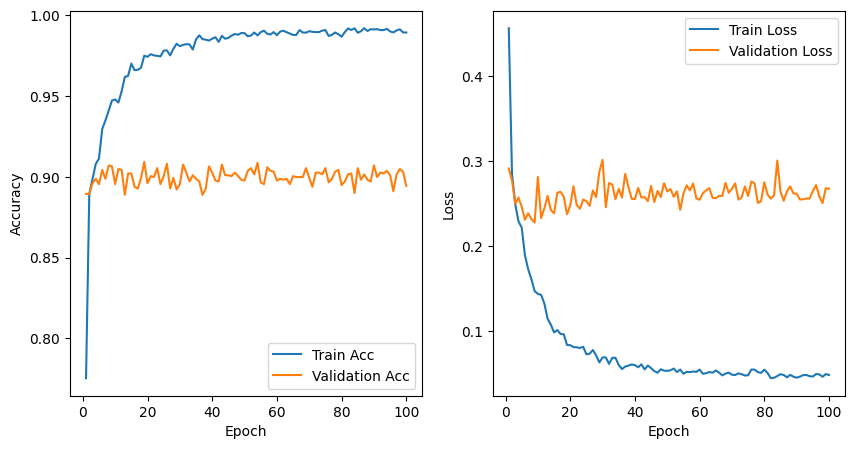

In [77]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

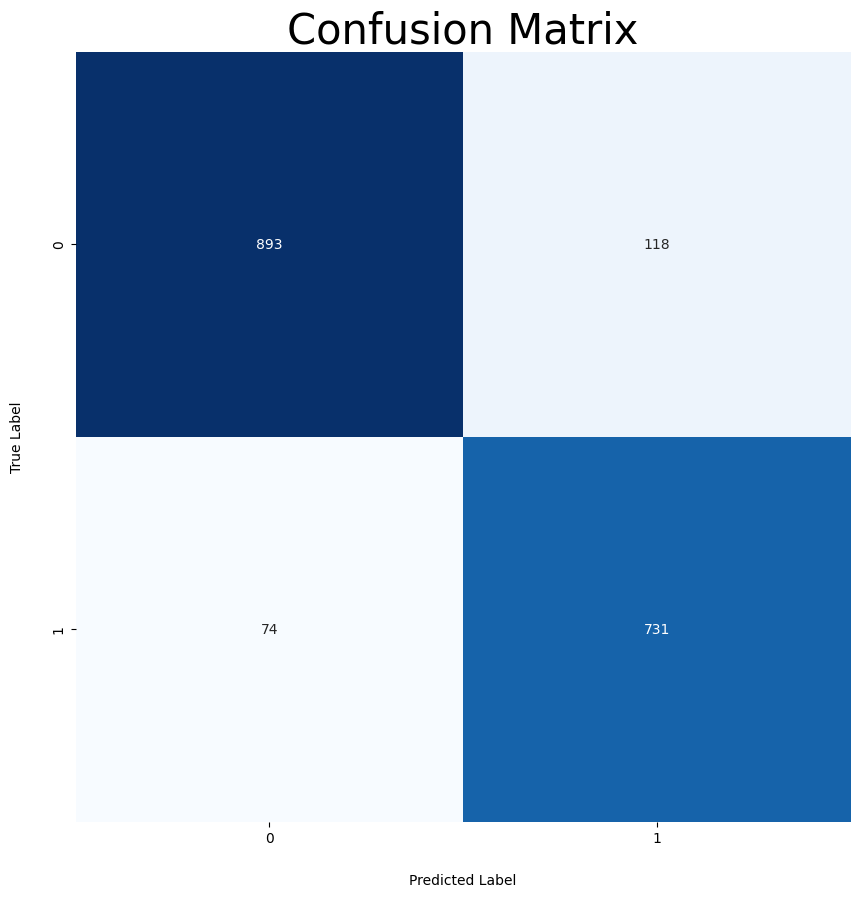

In [78]:
cnn_model_report = generate_confusion_matrix(
    model=model_1,
    dataset=valid_dataset,
)

In [79]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.896
F1:        0.893
Precision: 0.892
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1011
           1       0.86      0.91      0.88       805

    accuracy                           0.89      1816
   macro avg       0.89      0.90      0.89      1816
weighted avg       0.90      0.89      0.89      1816



### New Network implementation

In [26]:
class CNN(nn.Module):
    def __init__(self, input_dim=300, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()

        # first layer
        self.conv1_3 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3)
        self.conv1_5 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5)
        self.conv1_7 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=7)

        # second layer
        self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv2_5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5)
        self.conv2_7 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7)

        # activation function
        self.relu = nn.ReLU()

        # local max pooling layer
        self.local_maxpool = nn.AdaptiveMaxPool1d(output_size=1)

        # global max pooling
        self.global_maxpool = nn.MaxPool1d(kernel_size=2, stride=2)

        # flatten layer
        self.flatten = nn.Flatten()

        # fully connected layes
        self.fc1 = nn.Linear(in_features=2304, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))

        # First convolutional block
        x1 = self.relu(self.conv1_3(x))
        x2 = self.relu(self.conv1_5(x))
        x3 = self.relu(self.conv1_7(x))

        x1 = self.global_maxpool(x1)
        x2 = self.global_maxpool(x2)
        x3 = self.global_maxpool(x3)


        # Second convolutional block
        x1 = self.relu(self.conv2_3(x1))
        x2 = self.relu(self.conv2_5(x2))
        x3 = self.relu(self.conv2_7(x3))

        x1 = self.global_maxpool(x1)
        x2 = self.global_maxpool(x2)
        x3 = self.global_maxpool(x3)

        # Local maxpooing
        x1 = self.global_maxpool(x1)
        x2 = self.global_maxpool(x2)
        x3 = self.global_maxpool(x3)

        # Concatenate along feature dimension
        x = torch.cat((x1, x2, x3), dim=2)

        # Flatten the ouput
        x = self.flatten(x)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [27]:
model_2 = CNN(input_dim=EMBEDDING_VECTOR_DIM, num_classes=NUM_CLASSES)

In [31]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model_2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

cnn_model_train_history_2 = train_model(
    model=model_2,
    batch_size=BATCH_SIZE,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=DEVICE
)

device: cuda
model CNN(
  (conv1_3): Conv1d(300, 64, kernel_size=(3,), stride=(1,))
  (conv1_5): Conv1d(300, 64, kernel_size=(5,), stride=(1,))
  (conv1_7): Conv1d(300, 64, kernel_size=(7,), stride=(1,))
  (conv2_3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (conv2_5): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (conv2_7): Conv1d(64, 128, kernel_size=(7,), stride=(1,))
  (relu): ReLU()
  (local_maxpool): AdaptiveMaxPool1d(output_size=1)
  (global_maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


(Eval):  90%|████████▉ | 26/29 [00:00<00:00, 58.57it/s, accuracy=0.867, loss=0.369]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


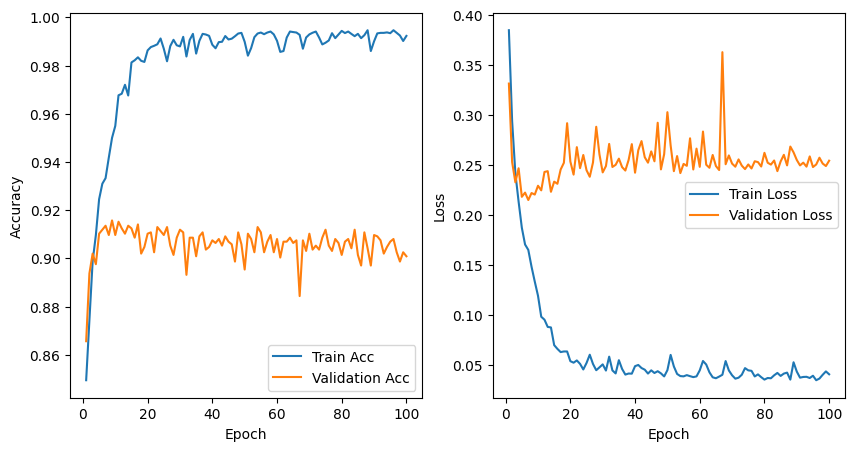

In [32]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history_2["train_acc"]),
            ("Validation Acc", cnn_model_train_history_2["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history_2["train_loss"]),
            ("Validation Loss", cnn_model_train_history_2["valid_loss"])
        ]
    }
)

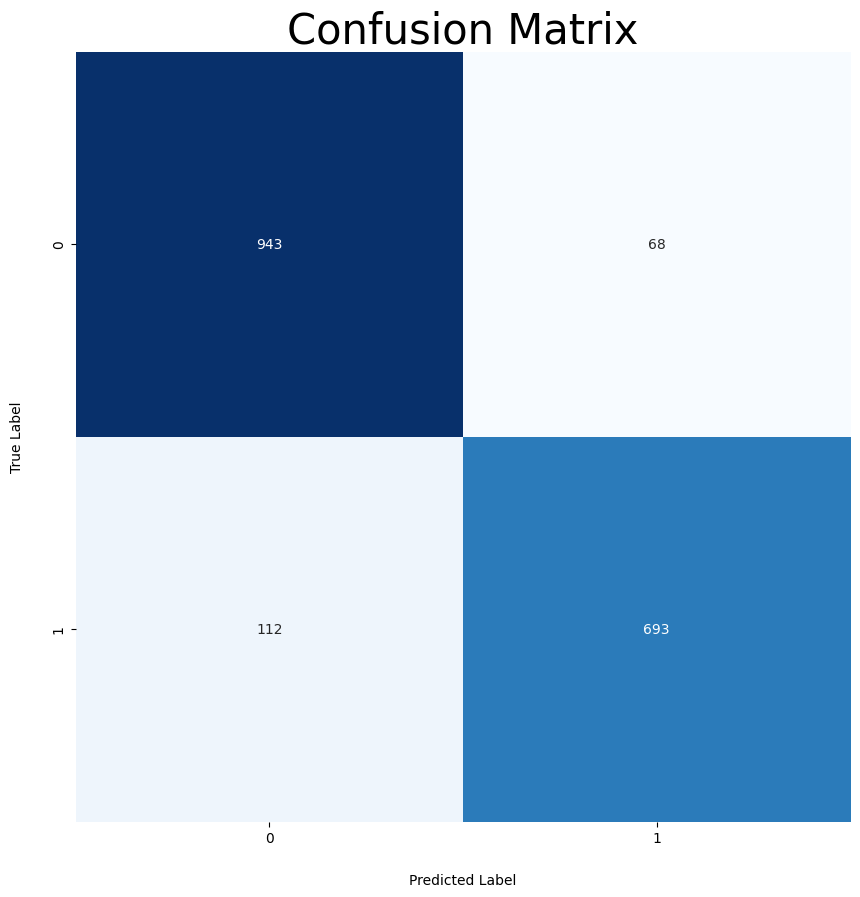

In [33]:
cnn_model_report_2 = generate_confusion_matrix(
    model=model_2,
    dataset=valid_dataset,
)

In [34]:
print(f"Recall:    {cnn_model_report_2['recall']:.3f}")
print(f"F1:        {cnn_model_report_2['f1']:.3f}")
print(f"Precision: {cnn_model_report_2['precision']:.3f}")
print(cnn_model_report_2['report'])

Recall:    0.897
F1:        0.899
Precision: 0.902
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1011
           1       0.91      0.86      0.89       805

    accuracy                           0.90      1816
   macro avg       0.90      0.90      0.90      1816
weighted avg       0.90      0.90      0.90      1816



### Network with sequence len=196

In [81]:
train_dataset_with_len_196 = Twitter(
    dataframe=train_df, w2v_model=w2v_model, sequence_len=SEQUENCE_LEN[1]
)
valid_dataset_with_len_196 = Twitter(
    dataframe=valid_df, w2v_model=w2v_model, sequence_len=SEQUENCE_LEN[1]
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

Deleted 0-Len Samples: 23


<ipython-input-14-19482a6e0654>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


Deleted 0-Len Samples: 8
Train dataset length: 7272
Valid dataset length: 1816


<ipython-input-14-19482a6e0654>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [94]:
class CNN(nn.Module):
    def __init__(self, input_dim=300, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()

        # first layer
        self.conv1_3 = nn.Conv1d(in_channels=input_dim, out_channels=196, kernel_size=3)
        self.conv1_5 = nn.Conv1d(in_channels=input_dim, out_channels=196, kernel_size=5)
        self.conv1_7 = nn.Conv1d(in_channels=input_dim, out_channels=196, kernel_size=7)

        # second layer
        self.conv2_3 = nn.Conv1d(in_channels=196, out_channels=128, kernel_size=3)
        self.conv2_5 = nn.Conv1d(in_channels=196, out_channels=128, kernel_size=5)
        self.conv2_7 = nn.Conv1d(in_channels=196, out_channels=128, kernel_size=7)

        # activation function
        self.relu = nn.ReLU()

        # local max pooling layer
        self.local_maxpool = nn.AdaptiveMaxPool1d(output_size=1)

        # global max pooling
        self.global_maxpool = nn.MaxPool1d(kernel_size=2, stride=2)

        # flatten layer
        self.flatten = nn.Flatten()

        # fully connected layes
        self.fc1 = nn.Linear(in_features=5376, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))

        # First convolutional block
        x1 = self.relu(self.conv1_3(x))
        x2 = self.relu(self.conv1_5(x))
        x3 = self.relu(self.conv1_7(x))

        x1 = self.global_maxpool(x1)
        x2 = self.global_maxpool(x2)
        x3 = self.global_maxpool(x3)


        # Second convolutional block
        x1 = self.relu(self.conv2_3(x1))
        x2 = self.relu(self.conv2_5(x2))
        x3 = self.relu(self.conv2_7(x3))

        x1 = self.global_maxpool(x1)
        x2 = self.global_maxpool(x2)
        x3 = self.global_maxpool(x3)

        # Local maxpooing
        x1 = self.global_maxpool(x1)
        x2 = self.global_maxpool(x2)
        x3 = self.global_maxpool(x3)

        # Concatenate along feature dimension
        x = torch.cat((x1, x2, x3), dim=2)

        # Flatten the ouput
        x = self.flatten(x)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [95]:
model_with_size_196 = CNN(input_dim=EMBEDDING_VECTOR_DIM, num_classes=NUM_CLASSES)

In [96]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model_with_size_196.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

cnn_model_train_history_with_size_196 = train_model(
    model=model_with_size_196,
    batch_size=BATCH_SIZE,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset_with_len_196,
    valid_set=valid_dataset_with_len_196,
    device=DEVICE
)

device: cuda
model CNN(
  (conv1_3): Conv1d(300, 196, kernel_size=(3,), stride=(1,))
  (conv1_5): Conv1d(300, 196, kernel_size=(5,), stride=(1,))
  (conv1_7): Conv1d(300, 196, kernel_size=(7,), stride=(1,))
  (conv2_3): Conv1d(196, 128, kernel_size=(3,), stride=(1,))
  (conv2_5): Conv1d(196, 128, kernel_size=(5,), stride=(1,))
  (conv2_7): Conv1d(196, 128, kernel_size=(7,), stride=(1,))
  (relu): ReLU()
  (local_maxpool): AdaptiveMaxPool1d(output_size=1)
  (global_maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=5376, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


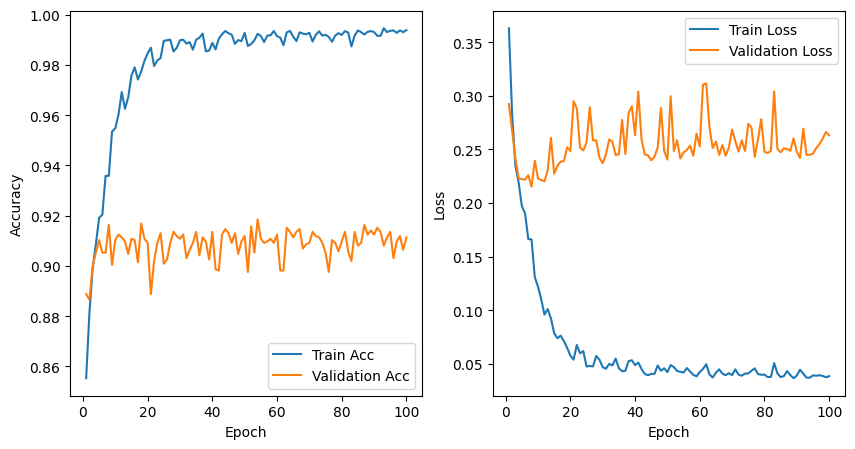

In [97]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history_with_size_196["train_acc"]),
            ("Validation Acc", cnn_model_train_history_with_size_196["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history_with_size_196["train_loss"]),
            ("Validation Loss", cnn_model_train_history_with_size_196["valid_loss"])
        ]
    }
)

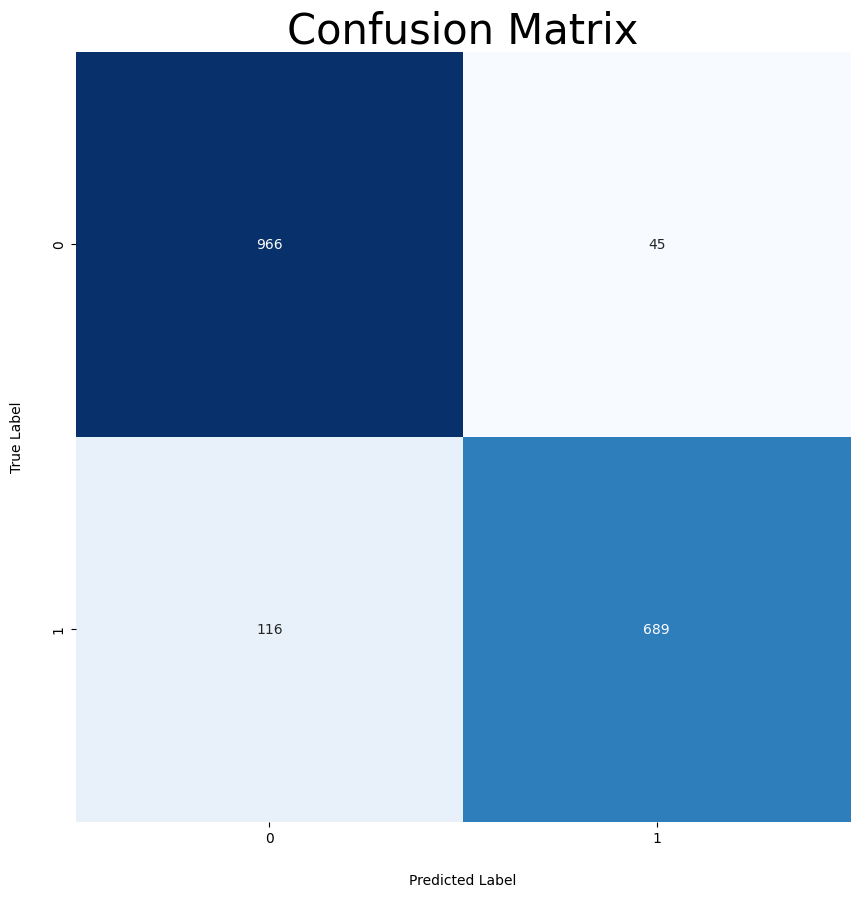

In [99]:
cnn_model_report_size_196 = generate_confusion_matrix(
    model=model_with_size_196,
    dataset=valid_dataset_with_len_196,
)

In [100]:
print(f"Recall:    {cnn_model_report_size_196['recall']:.3f}")
print(f"F1:        {cnn_model_report_size_196['f1']:.3f}")
print(f"Precision: {cnn_model_report_size_196['precision']:.3f}")
print(cnn_model_report_size_196['report'])

Recall:    0.906
F1:        0.909
Precision: 0.916
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1011
           1       0.94      0.86      0.90       805

    accuracy                           0.91      1816
   macro avg       0.92      0.91      0.91      1816
weighted avg       0.91      0.91      0.91      1816



### Model with regularization

In [62]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_dim=300, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()

        # First layer
        self.conv1_3 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3)
        self.bn1_3 = nn.BatchNorm1d(num_features=64)

        self.conv1_5 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5)
        self.bn1_5 = nn.BatchNorm1d(num_features=64)

        self.conv1_7 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=7)
        self.bn1_7 = nn.BatchNorm1d(num_features=64)

        # Second layer
        self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn2_3 = nn.BatchNorm1d(num_features=128)

        self.conv2_5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5)
        self.bn2_5 = nn.BatchNorm1d(num_features=128)

        self.conv2_7 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7)
        self.bn2_7 = nn.BatchNorm1d(num_features=128)

        # Activation function
        self.relu = nn.ReLU()

        # Local max pooling layer
        self.local_maxpool = nn.AdaptiveMaxPool1d(output_size=1)

        # Global max pooling
        self.global_maxpool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=384, out_features=128)
        self.bn_fc1 = nn.BatchNorm1d(num_features=128)
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))

        # First convolutional block
        x1 = self.relu(self.bn1_3(self.conv1_3(x)))
        x2 = self.relu(self.bn1_5(self.conv1_5(x)))
        x3 = self.relu(self.bn1_7(self.conv1_7(x)))

        x1 = self.global_maxpool(x1)
        x2 = self.global_maxpool(x2)
        x3 = self.global_maxpool(x3)

        # Second convolutional block
        x1 = self.relu(self.bn2_3(self.conv2_3(x1)))
        x2 = self.relu(self.bn2_5(self.conv2_5(x2)))
        x3 = self.relu(self.bn2_7(self.conv2_7(x3)))

        x1 = self.global_maxpool(x1)
        x2 = self.global_maxpool(x2)
        x3 = self.global_maxpool(x3)

        # local max pooling
        x1 = self.local_maxpool(x1)
        x2 = self.local_maxpool(x2)
        x3 = self.local_maxpool(x3)

        # Concatenate along feature dimension
        x = torch.cat((x1, x2, x3), dim=2)

        # Flatten
        x = self.flatten(x)

        # Fully connected layers with dropout and batch normalization
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.dropout2(x)
        return x

In [63]:
model_with_regularization = CNN(input_dim=EMBEDDING_VECTOR_DIM, num_classes=NUM_CLASSES)

In [64]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model_with_regularization.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

cnn_model_train_history_with_regularization = train_model(
    model=model_with_regularization,
    batch_size=BATCH_SIZE,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=DEVICE
)

device: cuda
model CNN(
  (conv1_3): Conv1d(300, 64, kernel_size=(3,), stride=(1,))
  (bn1_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_5): Conv1d(300, 64, kernel_size=(5,), stride=(1,))
  (bn1_5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_7): Conv1d(300, 64, kernel_size=(7,), stride=(1,))
  (bn1_7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (bn2_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_5): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (bn2_5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_7): Conv1d(64, 128, kernel_size=(7,), stride=(1,))
  (bn2_7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (local_maxpool): AdaptiveMaxPool1d(output_size=1

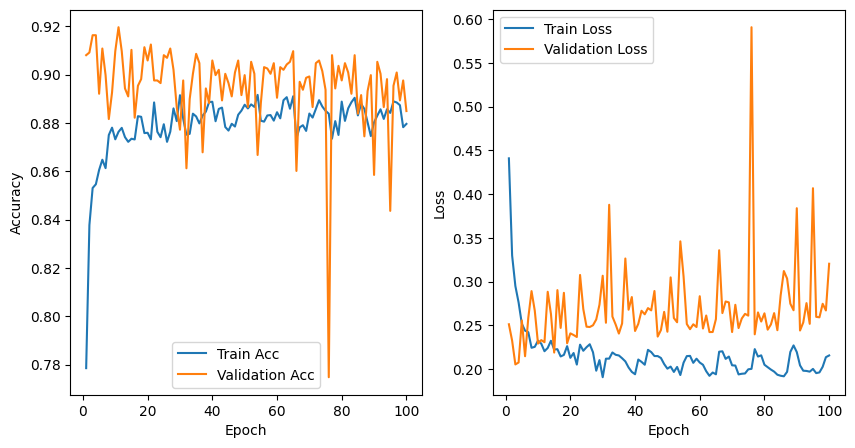

In [65]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history_with_regularization["train_acc"]),
            ("Validation Acc", cnn_model_train_history_with_regularization["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history_with_regularization["train_loss"]),
            ("Validation Loss", cnn_model_train_history_with_regularization["valid_loss"])
        ]
    }
)

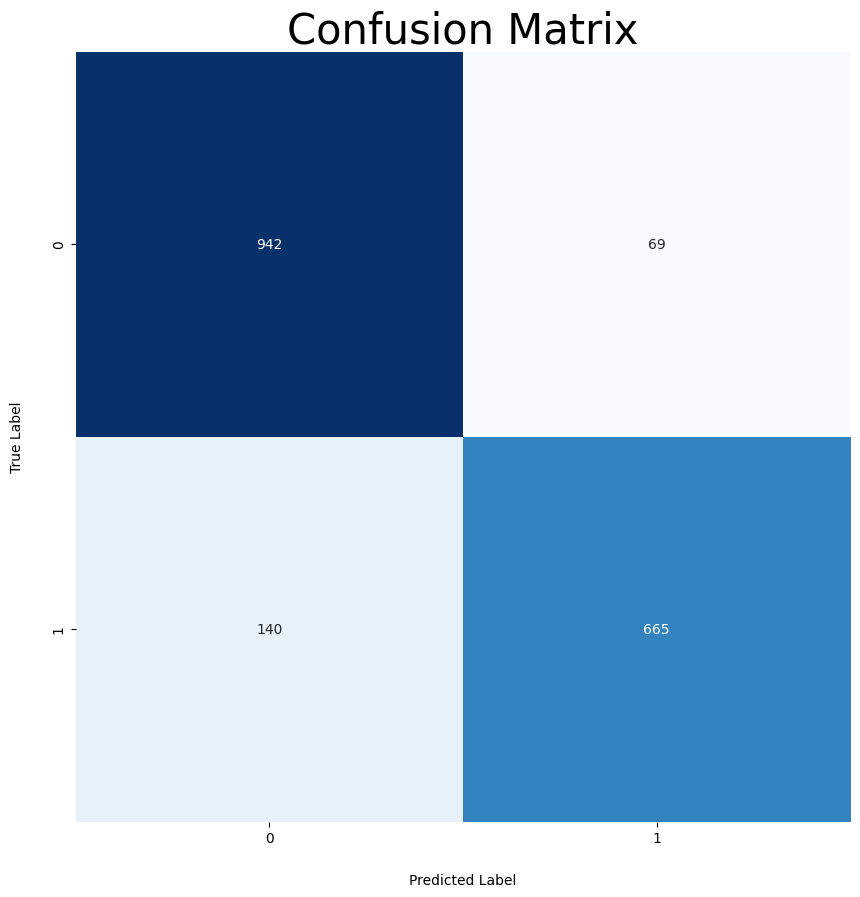

In [66]:
cnn_model_report_with_regularization = generate_confusion_matrix(
    model=model_with_regularization,
    dataset=valid_dataset,
)

In [67]:
print(f"Recall:    {cnn_model_report_with_regularization['recall']:.3f}")
print(f"F1:        {cnn_model_report_with_regularization['f1']:.3f}")
print(f"Precision: {cnn_model_report_with_regularization['precision']:.3f}")
print(cnn_model_report_with_regularization['report'])

Recall:    0.879
F1:        0.882
Precision: 0.888
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1011
           1       0.91      0.83      0.86       805

    accuracy                           0.88      1816
   macro avg       0.89      0.88      0.88      1816
weighted avg       0.89      0.88      0.88      1816



### Suggested network with regularization

In [101]:
class CNN(nn.Module):
    def __init__(self, input_dim=300, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()

        # first layer
        self.conv1_3 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3)
        self.conv1_5 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5)
        self.conv1_7 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=7)
        self.bn1_3 = nn.BatchNorm1d(num_features=64)

        # second layer
        self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv2_5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5)
        self.conv2_7 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7)
        self.bn2_3 = nn.BatchNorm1d(num_features=128)

        # activation function
        self.relu = nn.ReLU()

        # max poolinf layer
        self.maxpool = nn.AdaptiveMaxPool1d(output_size=1)

        # flatten layer
        self.flatten = nn.Flatten()

        # fully connected layes
        self.fc1 = nn.Linear(in_features=3 * 128, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

        # Batch morm and dropout
        self.bn_fc1 = nn.BatchNorm1d(num_features=128)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))

        # First convolutional block
        x1 = self.relu(self.bn1_3(self.conv1_3(x)))
        x2 = self.relu(self.bn1_3(self.conv1_5(x)))
        x3 = self.relu(self.bn1_3(self.conv1_7(x)))


        # Second convolutional block
        x1 = self.relu(self.bn2_3(self.conv2_3(x1)))
        x2 = self.relu(self.bn2_3(self.conv2_5(x2)))
        x3 = self.relu(self.bn2_3(self.conv2_7(x3)))


        # Local maxpooling
        x1 = self.maxpool(x1)
        x2 = self.maxpool(x2)
        x3 = self.maxpool(x3)

        # Concatenate along feature dimension
        x = torch.cat((x1, x2, x3), dim=2)

        # Flatten the output
        x = self.flatten(x)

        # Apply fully connected layers
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [102]:
model_with_regularization_on_suggested_network = CNN(input_dim=EMBEDDING_VECTOR_DIM, num_classes=2)

In [103]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model_with_regularization_on_suggested_network.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

cnn_model_train_history_with_regularization_on_suggested_network = train_model(
    model=model_with_regularization_on_suggested_network,
    batch_size=BATCH_SIZE,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=DEVICE
)

device: cuda
model CNN(
  (conv1_3): Conv1d(300, 64, kernel_size=(3,), stride=(1,))
  (conv1_5): Conv1d(300, 64, kernel_size=(5,), stride=(1,))
  (conv1_7): Conv1d(300, 64, kernel_size=(7,), stride=(1,))
  (bn1_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (conv2_5): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (conv2_7): Conv1d(64, 128, kernel_size=(7,), stride=(1,))
  (bn2_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): AdaptiveMaxPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (bn_fc1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


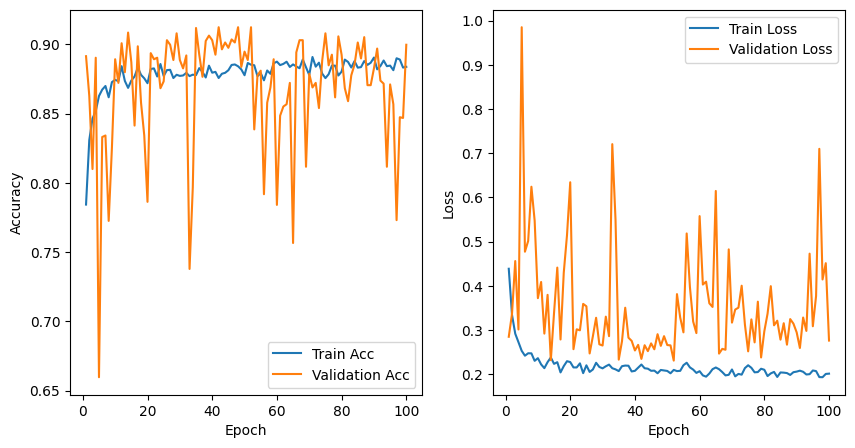

In [104]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history_with_regularization_on_suggested_network["train_acc"]),
            ("Validation Acc", cnn_model_train_history_with_regularization_on_suggested_network["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history_with_regularization_on_suggested_network["train_loss"]),
            ("Validation Loss", cnn_model_train_history_with_regularization_on_suggested_network["valid_loss"])
        ]
    }
)

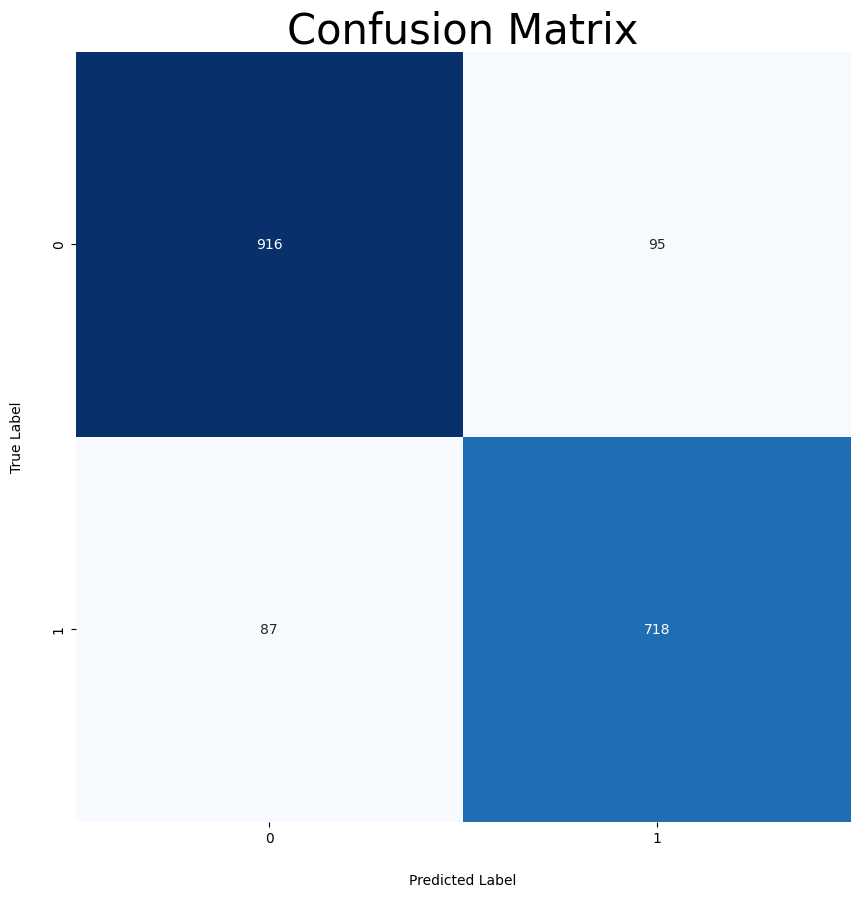

In [105]:
cnn_model_report_with_regularization_on_suggested_betwork = generate_confusion_matrix(
    model=model_with_regularization_on_suggested_network,
    dataset=valid_dataset,
)

In [106]:
print(f"Recall:    {cnn_model_report_with_regularization_on_suggested_betwork['recall']:.3f}")
print(f"F1:        {cnn_model_report_with_regularization_on_suggested_betwork['f1']:.3f}")
print(f"Precision: {cnn_model_report_with_regularization_on_suggested_betwork['precision']:.3f}")
print(cnn_model_report_with_regularization_on_suggested_betwork['report'])

Recall:    0.899
F1:        0.899
Precision: 0.898
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1011
           1       0.88      0.89      0.89       805

    accuracy                           0.90      1816
   macro avg       0.90      0.90      0.90      1816
weighted avg       0.90      0.90      0.90      1816



### Network without batch normalization

In [107]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_dim=300, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()

        # First layer
        self.conv1_3 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3)
        self.bn1_3 = nn.BatchNorm1d(num_features=64)

        self.conv1_5 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5)
        self.bn1_5 = nn.BatchNorm1d(num_features=64)

        self.conv1_7 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=7)
        self.bn1_7 = nn.BatchNorm1d(num_features=64)

        # Second layer
        self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn2_3 = nn.BatchNorm1d(num_features=128)

        self.conv2_5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5)
        self.bn2_5 = nn.BatchNorm1d(num_features=128)

        self.conv2_7 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7)
        self.bn2_7 = nn.BatchNorm1d(num_features=128)

        # Activation function
        self.relu = nn.ReLU()

        # Local max pooling layer
        self.local_maxpool = nn.AdaptiveMaxPool1d(output_size=1)

        # Global max pooling
        self.global_maxpool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=384, out_features=128)
        self.bn_fc1 = nn.BatchNorm1d(num_features=128)
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))

        # First convolutional block
        x1 = self.relu(self.conv1_3(x))
        x2 = self.relu(self.conv1_5(x))
        x3 = self.relu(self.conv1_7(x))

        x1 = self.global_maxpool(x1)
        x2 = self.global_maxpool(x2)
        x3 = self.global_maxpool(x3)

        # Second convolutional block
        x1 = self.relu(self.conv2_3(x1))
        x2 = self.relu(self.conv2_5(x2))
        x3 = self.relu(self.conv2_7(x3))

        x1 = self.global_maxpool(x1)
        x2 = self.global_maxpool(x2)
        x3 = self.global_maxpool(x3)

        # local max pooling
        x1 = self.local_maxpool(x1)
        x2 = self.local_maxpool(x2)
        x3 = self.local_maxpool(x3)

        # Concatenate along feature dimension
        x = torch.cat((x1, x2, x3), dim=2)

        # Flatten
        x = self.flatten(x)

        # Fully connected layers with dropout and batch normalization
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.dropout2(x)
        return x

In [108]:
TEST = CNN(input_dim=EMBEDDING_VECTOR_DIM, num_classes=NUM_CLASSES)

In [109]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(TEST.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

TEST_TRAIN = train_model(
    model=TEST,
    batch_size=BATCH_SIZE,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=DEVICE
)

device: cuda
model CNN(
  (conv1_3): Conv1d(300, 64, kernel_size=(3,), stride=(1,))
  (bn1_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_5): Conv1d(300, 64, kernel_size=(5,), stride=(1,))
  (bn1_5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_7): Conv1d(300, 64, kernel_size=(7,), stride=(1,))
  (bn1_7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (bn2_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_5): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (bn2_5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_7): Conv1d(64, 128, kernel_size=(7,), stride=(1,))
  (bn2_7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (local_maxpool): AdaptiveMaxPool1d(output_size=1

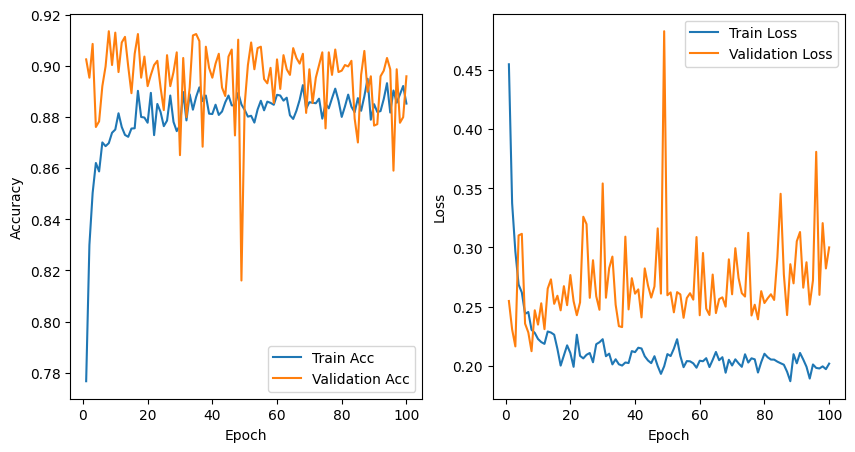

In [110]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", TEST_TRAIN["train_acc"]),
            ("Validation Acc", TEST_TRAIN["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", TEST_TRAIN["train_loss"]),
            ("Validation Loss", TEST_TRAIN["valid_loss"])
        ]
    }
)

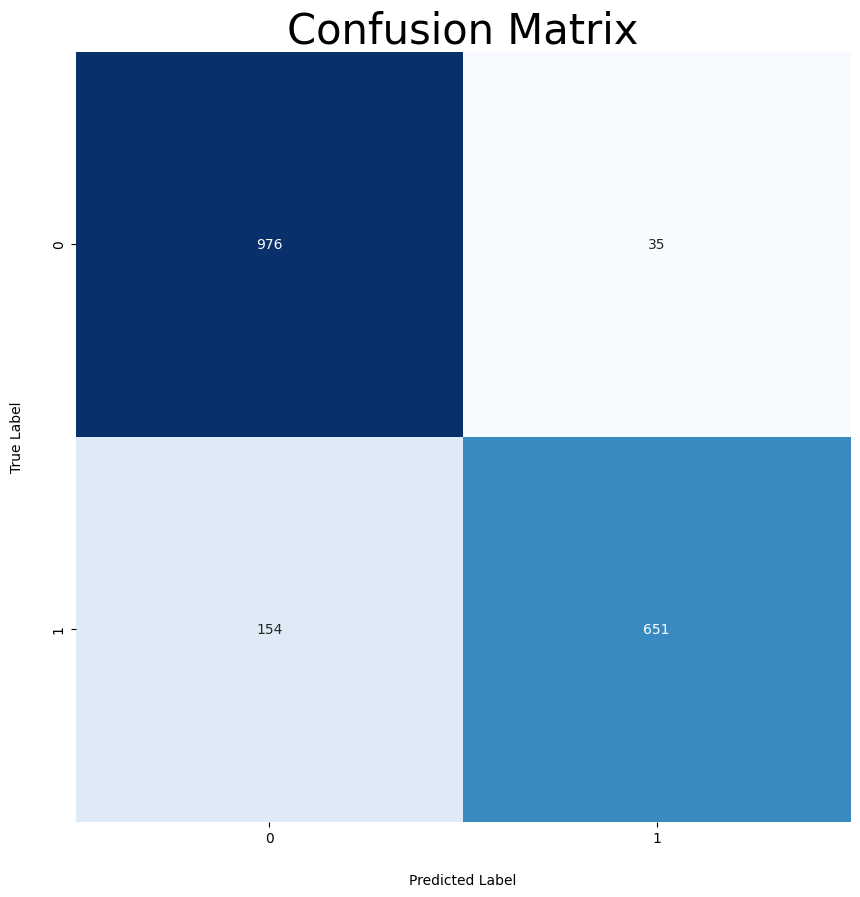

In [111]:
TEST_TARIN_CONF = generate_confusion_matrix(
    model=TEST,
    dataset=valid_dataset,
)

In [112]:
print(f"Recall:    {TEST_TARIN_CONF['recall']:.3f}")
print(f"F1:        {TEST_TARIN_CONF['f1']:.3f}")
print(f"Precision: {TEST_TARIN_CONF['precision']:.3f}")
print(TEST_TARIN_CONF['report'])

Recall:    0.887
F1:        0.892
Precision: 0.906
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1011
           1       0.95      0.81      0.87       805

    accuracy                           0.90      1816
   macro avg       0.91      0.89      0.89      1816
weighted avg       0.90      0.90      0.89      1816



## Questions

### Briefly explain the advantages and disadvantages of converting the text to lowercase format and tell why we do this processing in the end?
- **`Advantages`**:
    - `Consistency`: Converting text to lowercase ensures uniformity. For example, "Python" and "python" are treated as the same word, which helps in reducing the vocabulary size.
    - `Improved Matching`: Helps in better matching of words during the tokenization process. For example, "Machine" and "machine" would be considered the same word.
    - `Simplifies Processing`: Simplifies various text processing tasks such as stemming and lemmatization as these tasks become case-insensitive.
  
- **`Disadvantages`**:
    - `Loss of Information`: Certain information such as proper nouns (e.g., "Amazon" the company vs. "amazon" the rainforest) can be lost.
    - `Context Loss`: In some cases, the casing might carry contextual meaning which can be significant for understanding the text.
  
`Why We Do This Processing`:
We convert text to lowercase to achieve uniformity and simplicity in text processing. This step is usually done after all other text processing to ensure that any case-sensitive operations (like named entity recognition) are not affected.

### Research about the elimination of numbers in the above processes and name the advantages and disadvantages of this process.
- **`Advantages`**:
    - `Noise Reduction`: Numbers can add noise to the text data, especially if they are irrelevant to the text's meaning.
    - `Simplified Vocabulary`: Reduces the vocabulary size, making the model less complex and faster to train.
    - `Focus on Textual Data`: Helps the model focus on the textual content rather than numerical data, which might not be meaningful in some contexts.

- **`Disadvantages`**:
    - `Loss of Information`: Numbers can carry important information (e.g., dates, prices, quantities) which, when removed, can lead to loss of valuable context.
    - `Contextual Importance`: In some domains like finance or sports, numbers play a crucial role and their removal can significantly affect the model's performance.


### We have the ability to use hashtags in the Twitter social network. Explain why these phrases are removed, and what effect does keeping them have on the performance of the model?
- **`Advantages of Removing Hashtags`**:
    - `Noise Reduction`: Hashtags often contain meta-information or are used for trending purposes, which may not contribute to the actual content meaning.
    - `Simplified Text`: Removing hashtags can simplify the text, making it cleaner and more focused on the actual message.

- **`Disadvantages of Removing Hashtags`**:
    - `Loss of Context`: Hashtags can provide context or sentiment (e.g., #Happy, #BreakingNews). Removing them might lead to loss of valuable contextual information.
    - `Trend Information`: Hashtags can indicate trending topics or categorize tweets, which can be useful for certain types of analysis.

`Effect on Model Performance`:
Keeping hashtags can improve the model's ability to understand trends and context, especially in sentiment analysis or topic modeling. However, it can also introduce noise if the hashtags are overly used or irrelevant.

### Explain what methods there are for dealing with non-existent words in the mentioned dictionary and name the advantages and disadvantages of each.

1. **`Random Initialization`**:

- `Method`: Assign a random vector to each unknown word.
- `Advantages`:
    - Easy to implement.  
    - Introduces some variability which might help in learning diverse patterns.
-  `Disadvantages`:
    - Random vectors may not capture meaningful semantic information.
    - Can introduce noise, leading to less stable and potentially less accurate model performance.


2. **`Zero Vector`**:

- `Method`: Assign a zero vector to each unknown word.
- `Advantages`:
    - Simple and straightforward.
    - Ensures that unknown words do not contribute to the model's predictions.
- `Disadvantages`:
    - Completely ignores the unknown words, which might result in loss of potentially useful information.
    - Can negatively impact model performance if unknown words are frequent.

3. **`Use a Special Token (e.g., <UNK>)`**:

- `Method`: Assign a single vector for all unknown words, representing them with a special token like <UNK>.
- `Advantages`:
    - Provides a consistent representation for all unknown words.
    - Helps the model learn to deal with unknown words in a uniform way.
- `Disadvantages`:
    - Treats all unknown words as if they were the same, which might not capture the nuanced differences between them.
    - The special token's vector might not be as informative as known words' vectors.

4. **`Average of Known Words`**:

- `Method`: Use the average vector of all known words in the vocabulary as the vector for unknown words.
- `Advantages`:
    - Provides a more informative and meaningful representation than a random or zero vector.
    - Balances between ignoring unknown words and providing a random representation.
- `Disadvantages`:
    - Computationally more expensive, as it requires calculating the average vector.
    - Still a generic representation that might not be specific to the context of the unknown word.

5. **`Nearest Neighbor Approximation`**:

- `Method`: Find the nearest known word(s) in the vector space and use their vector(s) as a proxy for the unknown word.
- `Advantages`:
    - Provides a more contextually relevant representation compared to random or zero vectors.
    - Can leverage the semantic similarity in the vector space.
- `Disadvantages`:
    - Requires a search through the vocabulary, which can be computationally intensive.
    - The approximation might still be incorrect if the nearest neighbor is not sufficiently similar.

6. **`Character-level Embeddings`**:

- `Method`: Use character-level embeddings (e.g., Char-CNN, Char-RNN) to generate vectors for unknown words based on their character composition.
- `Advantages`:
    - Can generate meaningful representations for previously unseen words.
    - Captures morphological information, which can be useful for understanding rare or complex words.
- `Disadvantages`:
    - Adds complexity to the model.
    - Requires additional computational resources for training and inference.

### Briefly explain how the Adam optimizer works and how it differs from the SGD optimizer.

The Adam (Adaptive Moment Estimation) optimizer is an advanced gradient descent algorithm designed to combine the best properties of the AdaGrad and RMSProp optimizers. It adapts the learning rate for each parameter by keeping an exponentially decaying average of past gradients (first moment estimate) and past squared gradients (second moment estimate).

Here's a brief overview of how Adam works:

1. `Initialize`:
   - Initialize the first moment vector $ m_t $ and seond moment $ v_t $ to 0.
   - Initialize the time step $ t $ to 0.

2. `Compute Gradients`: 
   - At each time step, compute the gradient $ g_t $ of the loss function with respect to the parameters.

3. `Update Moment Estimates`:
   - Update biased first moment estimate: $ m_t = \beta_1 m_t-1 + (1 - \beta_1)g_t $
   - Update biased second moment estimate: $ v_t = \beta_2 v_t-1 + (1 - \beta_2)g_t^2 $

4. `Bias Correction`:
   - Correct the bias in moment estimates:
   - $ \hat m_t = \frac{m_t} {1 - \beta_1^t}$
   - $ \hat v_t = \frac{v_t} {1 - \beta_2^t}$

5. `Update Parameters`:
   - Update the parameters: $ \theta_t = \theta_{t-1} - \frac {\alpha \hat m_t} { \sqrt{\hat v_t} + \epsilon} $ 

 
`Differences from SGD`:
- `Learning Rate Adaptation`: Adam adapts the learning rate for each parameter individually, whereas SGD uses a single learning rate for all parameters.
- `Momentum`: Adam incorporates momentum (through the first moment estimate) and adapts the learning rate based on the variance of the gradients (through the second moment estimate). Traditional SGD does not adapt the learning rate and does not use second moment estimates.
- `Efficiency`: Adam tends to converge faster and often requires less tuning of the learning rate compared to SGD.

### Use the Cross Entropy cost function. Also, tell the reason for using this cost function according to the nature of the problem.
Cross-entropy loss, also known as log loss, is commonly used for classification tasks, especially in binary and multi-class classification problems. It measures the performance of a classification model whose output is a probability value between 0 and 1.

- `Formula`: 

For binary classification: $ - \frac {1}{N} \sum_{i=1}^N [y_i\log(\hat y_i) + (1 - y_i)\log(1 - \hat y_I)] $

For multi-class classification: $ - \frac {1}{N} \sum_{i=1}^N \sum_{j=1}^Cy_{ij}\log(\hat y_i)  $

`Reason for Using Cross-Entropy`:

- `Suitability for Probabilistic Outputs`: Cross-entropy loss is appropriate for tasks where the model outputs probabilities. It penalizes predictions that are far from the actual class.
- `Effectiveness in Training`: It provides a steep gradient, which helps in faster convergence during training.


### Data Division for Training and Testing
Ratio and Reason:
Typically, the data is divided into training and testing sets in a ratio of 80:20 or 70:30. This ratio ensures that the training set is sufficiently large to train the model effectively while keeping a significant portion for unbiased evaluation.

### What is the effect of kernel size in convolution layers and how is it effective in extracting input features? What does it mean to be more or less?
- **`Feature Extraction`**: 
    
    - Larger kernels can capture more context and detect broader features but at the risk of losing fine details. Smaller kernels capture finer details but may miss the broader context.
    - Receptive Field: A larger kernel increases the receptive field of the convolutional layer, allowing the model to look at a larger portion of the input at a time.
    - Computational Complexity: Larger kernels increase the computational load and the number of parameters, leading to more complex and potentially slower models.

- **`Implications`**:
    - `Larger Kernels`: Better for high-level feature extraction where context is important.
    - `Smaller Kernels`: Better for low-level feature extraction where fine details are critical.

### In your opinion, why did we not reduce the convolution output and did this reduction through Feed Forward layers and what advantages can this layer have over alternative methods? Investigate the reason for this and state the results.
Reason for Not Reducing Convolution Output:

- `Retention of Information`: Reducing the size of convolutional output too early might lead to loss of important spatial information. Instead, fully connected layers can be used to learn complex patterns and interactions after the convolutional layers have extracted hierarchical features.
- `Complex Relationships`: Feed forward layers can model complex relationships between features, enhancing the model's ability to learn from high-level abstractions.

- **`Advantages of Feed Forward Layers`**:

- `Flexibility`: They allow the model to learn non-linear combinations of features extracted by convolutional layers.
- `Adaptability`: Fully connected layers are highly adaptable and can work well with high-dimensional feature spaces.
- `Powerful Representations`: They help in learning powerful representations that can improve the model's predictive performance.

### In your opinion, increasing the size of the text window, so that it is more than all the sentences in the dataset, what advantages and disadvantages can it have in a convolutional neural network.

**`Advantages`**

1. `Complete Context Capture`:
   - Detailed Context Understanding: By having a text window larger than the longest sentence, the model can capture the entire context of each sentence, ensuring that no part of the text is truncated. This helps in understanding the full meaning and nuances of the text.
   - Better Feature Extraction: Longer text windows allow the CNN to extract features from a larger context, potentially capturing more complex patterns and dependencies within the text.

2. `Avoid Information Loss`:
    - `Preserve Information`: When the window size is smaller than some of the sentences, parts of those sentences get truncated, leading to information loss. A larger window prevents this, ensuring that all relevant information is available for the model to learn from.
    - `Improved Model Performance`: Preserving the entire input text can lead to improved performance, especially for tasks that rely on understanding the complete context, such as sentiment analysis or text classification.

**`Disadvantages`**
1. `Increased Computational Cost`:
    - `Higher Resource Consumption`: Larger text windows result in more data being processed at once, increasing the computational load on the GPU/CPU. This can lead to higher memory usage and longer training times.
    - `Complexity and Time`: Training with larger inputs requires more computational power and can significantly slow down the training process. This might also necessitate the use of more powerful hardware.

2. `Overfitting Risk`:
    - `More Parameters`: Larger input sizes can lead to an increase in the number of parameters in the model, particularly if the convolutional layers are followed by fully connected layers. This can increase the risk of overfitting, where the model learns to perform well on the training data but generalizes poorly to unseen data.
    - `Model Complexity`: Managing a larger model complexity can be challenging and may require more regularization techniques, such as dropout or batch normalization, to prevent overfitting.
  
3. `Data Sparsity Issues`:
    - `Sparse Data`: If the majority of sentences are much shorter than the window size, a lot of padding (e.g., zeros) will be added to reach the required length. This can lead to sparsity in the data, where the input contains more padding than actual content, potentially diluting the useful information and making it harder for the model to learn effectively.
    - `Noise Introduction`: Excessive padding can introduce noise and make the learning process less efficient, as the model needs to learn to ignore the padded parts.

4. `Increased Difficulty in Hyperparameter Tuning`:
   - `Longer Hyperparameter Search`: With a larger input size, finding the optimal hyperparameters (such as learning rate, batch size, etc.) can become more complex and time-consuming. The model's sensitivity to these parameters may increase, requiring more extensive experimentation.

### Resources
https://people.engr.tamu.edu/huangrh/Spring18/project_presentation_04_26.pdf \
https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739 \
https://www.geeksforgeeks.org/batch-normalization-implementation-in-pytorch/ \
https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c \
https://www.analyticsvidhya.com/blog/2021/09/natural-language-processing-using-cnns-for-sentence-classification/ \
https://towardsdatascience.com/nlp-with-cnns-a6aa743bdc1e \
https://asjamieson.medium.com/convolutional-neural-networks-cnn-with-text-f1b438be5466 \
https://medium.com/@divakar1591/implementing-a-cnn-for-text-classification-in-tensorflow-f7d7d8f227bc \
https://medium.com/analytics-vidhya/cnn-quick-learn-12dced578b01 \
https://medium.com/machine-learning-researcher/convlutional-neural-network-cnn-2fc4faa7bb63 \
https://www.analyticsvidhya.com/blog/2021/08/beginners-guide-to-convolutional-neural-network-with-implementation-in-python/ \
https://www.youtube.com/watch?v=Qf06XDYXCXI&list=PLblh5JKOoLUIxGDQs4LFFD--41Vzf-ME1 \
https://www.youtube.com/watch?v=RgIa3_BjGyk \
https://www.youtube.com/watch?v=LIRwZDEMn2o&list=PLTl9hO2Oobd_bzXUpzKMKA3liq2kj6LfE \
https://towardsdatascience.com/deep-learning-techniques-for-text-classification-78d9dc40bf7c \
https://vasista.medium.com/deep-learning-vs-machine-learning-with-text-classification-162ea20a7924 \
and ChatGPT :)